### Questions:
* How to reduce detection delay keeping good detection level?
* How should detector behave when it gets totally scattered signal? Should it try to detect some peaks? Or maybe it is better to give nothing and avoid false positives?
* Shoud signal be normalized after every processing step

### Tuning:
* Change spki and npki exponential filter params.
* Threshold 1 is too little reactive on disturbances in raw signal - make it easier to qualify peak as noise (e.g. pulse17.csv).
* After threshold 1 key importance is fiducial mark (peak) detection in integrated signal. Test how does it work (how much does it detect) for different datasets.
* After that there is differentiation parameters.
* Signal filtration optimization.
* spki, npki, threshold1 and threshold2 init.


* paper: maybe it would shorten detection delay if fiducial mark detected beginning of the integrated signal peak?

* paper: check on different test datasets whether algo behaves when there is noise - like in the paper

In [388]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks_cwt

In [389]:
## Signal processing containers.
raw_signal = np.array([])
filtered = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

## Fiducial mark.
fiducial_mark_idx = np.array([])
fiducial_mark_val_i = np.array([])
fiducial_mark_val_f = np.array([])

## Integrated signal detection and thresholding.
spk_i = 0.0 
npk_i = 0.0 
threshold_i_1 = 0.0
threshold_i_2 = 0.0 
qrs_peak_i = np.array([])
noise_peak_i = np.array([])

peak_vals_i = np.array([])
spk_i_vals = np.array([])
npk_i_vals = np.array([])
threshold_i_1_vals = np.array([])
threshold_i_2_vals = np.array([])

## Filtered signal detection and thresholding.
spk_f = 0.0 
npk_f = 0.0 
threshold_f_1 = 0.0
threshold_f_2 = 0.0 
qrs_peak_f = np.array([])
noise_peak_f = np.array([])

peak_vals_f = np.array([])
spk_f_vals = np.array([])
npk_f_vals = np.array([])
threshold_f_1_vals = np.array([])
threshold_f_2_vals = np.array([])

(0.0, 199.0, 0.30303029999999997, 3.46529818)

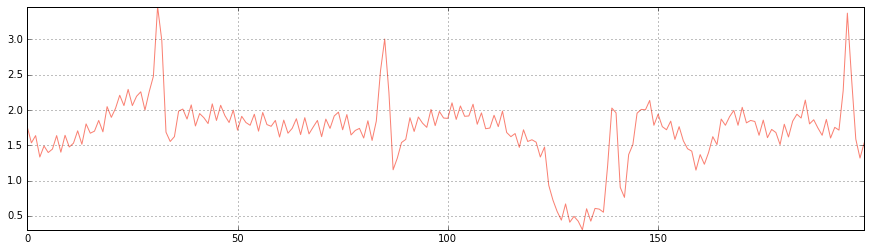

In [390]:
## Load and clean data.
with open("data/pulse8.csv") as f:
    content = f.readlines()
raw_data = []
for line in content:
    raw_signal = np.append(raw_signal, float(line.rstrip().split(';')[1]))
# raw_signal = raw_signal / max(raw_signal)

plt.figure(figsize=(15,4))
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

(0.0, 199.0, 0.40076620700233367, 3.0530653566977102)

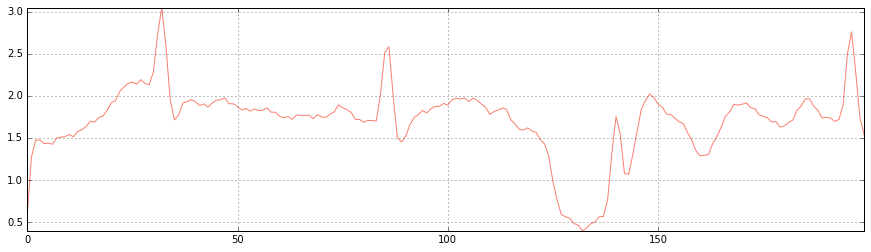

In [391]:
## Signal filtering methods.
def butter_bandpass_filter(data, lowcut, highcut, signal_freq, order):
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

## Signal filtering - pass band 0-12 Hz.
filtered_signal = butter_bandpass_filter(raw_signal, lowcut=0.0, highcut=12.0, signal_freq=84.0, order=1)
# filtered_signal = filtered_signal / max(filtered_signal)

plt.figure(figsize=(15,4))
plt.plot(filtered_signal, label="Filtered signal", color="salmon")
plt.grid(True)
plt.axis("tight")

(0.0, 198.0, -0.62853475127879954, 0.69952333475581507)

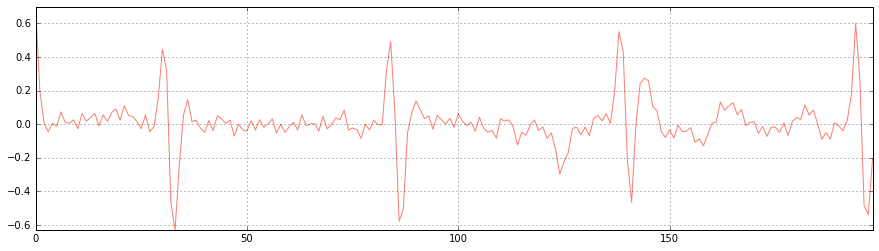

In [392]:
## Derivative original - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(filtered_signal)
# differentiated_signal = filtered_signal
# differentiated_signal = differentiated_signal / max(differentiated_signal)

plt.figure(figsize=(15,4))
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

(0.0, 198.0, 7.2712024274781277e-08, 0.48933289586789613)

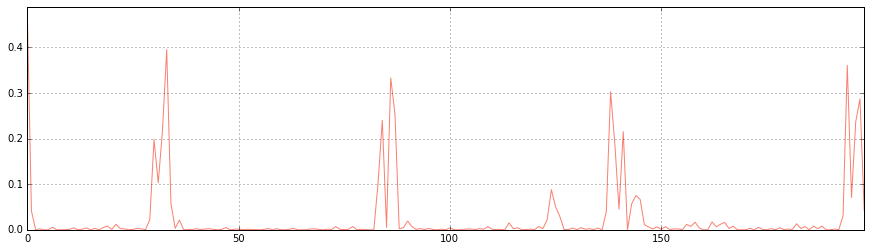

In [393]:
## Squaring - signal is squared point by point.
squared_signal = np.power(differentiated_signal, 2)
# squared_signal = squared_signal / max(squared_signal)

plt.figure(figsize=(15,4))
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

(0.0, 209.0, 0.00085601253674719385, 0.086737391318977161)

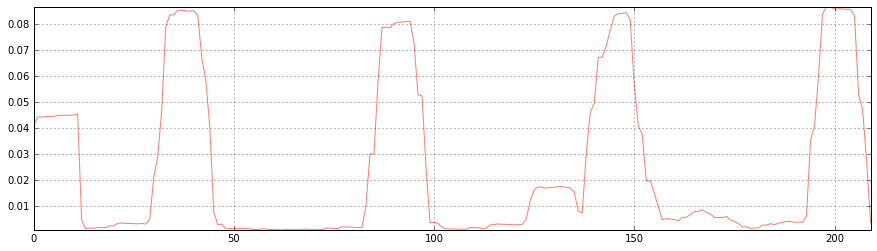

In [394]:
## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
N = 12
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)
# integrated_signal = integrated_signal / max(integrated_signal) 

plt.figure(figsize=(15,4))
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

IndexError: list assignment index out of range

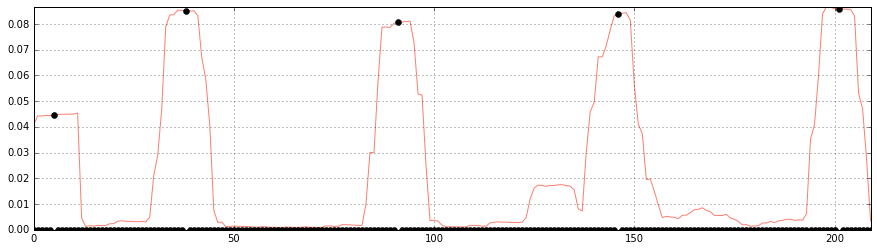

In [395]:
## Fiducial mark - peak detection - integrated signal.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val_i = np.append(fiducial_mark_val_i, integrated_signal[peak_index])
    fiducial_mark_val_f = np.append(fiducial_mark_val_f, filtered_signal[peak_index-7])
    
fiducial_mark_indication_i = [0] * len(integrated_signal)
for peak_idx, peak_val_i in zip(fiducial_mark_idx, fiducial_mark_val_i):
    fiducial_mark_indication_i[int(peak_idx)] = peak_val_i

plt.figure(figsize=(15,4))
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication_i, 'ko')
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication_f = [0] * len(filtered_signal)
for peak_idx, peak_val_f in zip(fiducial_mark_idx, fiducial_mark_val_f):
    fiducial_mark_indication_f[int(peak_idx)] = peak_val_f
plt.figure(figsize=(15,4))
plt.plot(filtered_signal, label="Filtered signal", color="steelblue")
plt.plot(fiducial_mark_indication_f, 'ko')
plt.grid(True)
plt.axis("tight")

In [ ]:
## Thresholding detect peaks - integrated and filtered signal.
for peak_idx, peak_val_i, peak_val_f in zip(fiducial_mark_idx, fiducial_mark_val_i, fiducial_mark_val_f):
    if peak_val_i > threshold_i_1 and peak_val_f > threshold_f_1:
        spk_i = 0.125 * peak_val_i + 0.875 * spk_i
        spk_f = 0.125 * peak_val_f + 0.875 * spk_f
        print "pulse - peak_i: %f, spk_i: %f, threshold_i_1: %f" % (peak_val_i, spk_i, threshold_i_1)
        print "pulse - peak_f: %f, spk_f: %f, threshold_f_1: %f" % (peak_val_f, spk_f, threshold_f_1)
        
        qrs_peak_i = np.append(qrs_peak_f, peak_idx)
        spk_i_vals = np.append(spk_f_vals, spk_f)
        npk_i_vals = np.append(npk_f_vals, npk_f)
        threshold_i_1_vals = np.append(threshold_i_1_vals, threshold_i_1)
        threshold_i_2_vals = np.append(threshold_i_2_vals, threshold_i_2)
        
        qrs_peak_f = np.append(qrs_peak_f, peak_idx)
        spk_f_vals = np.append(spk_f_vals, spk_f)
        npk_f_vals = np.append(npk_f_vals, npk_f)
        threshold_f_1_vals = np.append(threshold_f_1_vals, threshold_f_1)
        threshold_f_2_vals = np.append(threshold_f_2_vals, threshold_f_2)
    else:
        npk_i = 0.125 * peak_val_i + 0.875 * npk_i
        npk_f = 0.125 * peak_val_f + 0.875 * npk_f
        print "noise - peak_i: %f, npk_i: %f, threshold_i_1: %f" % (peak_val_i, npk_i, threshold_i_1)
        print "noise - peak_f: %f, npk_f: %f, threshold_f_1: %f" % (peak_val_f, npk_f, threshold_f_1)
        
        noise_peak_i = np.append(noise_peak_i, peak_idx)
        spk_i_vals = np.append(spk_i_vals, spk_i)
        npk_i_vals = np.append(npk_i_vals, npk_i)
        threshold_i_1_vals = np.append(threshold_i_1_vals, threshold_i_1)
        threshold_i_2_vals = np.append(threshold_i_2_vals, threshold_i_2)
        
        noise_peak_f = np.append(noise_peak_f, peak_idx)
        spk_f_vals = np.append(spk_f_vals, spk_f)
        npk_f_vals = np.append(npk_f_vals, npk_f)
        threshold_f_1_vals = np.append(threshold_f_1_vals, threshold_f_1)
        threshold_f_2_vals = np.append(threshold_f_2_vals, threshold_f_2)
        
    peak_vals_i = np.append(peak_vals_i, peak_val_i)
    peak_vals_f = np.append(peak_vals_f, peak_val_f)
    
    threshold_i_1 = npk_i + 0.25 * (spk_i - npk_i)
    threshold_i_2 = 0.5 * threshold_i_1
    
    threshold_f_1 = npk_f + 0.25 * (spk_f - npk_f)
    threshold_f_2 = 0.5 * threshold_f_1
    

In [ ]:
## Plotting detected peaks - integrated signal.
qrs_peak_indication_i = [0] * len(integrated_signal)
for peak_i in qrs_peak_i:
    qrs_peak_indication_i[int(peak_i)] = raw_signal[int(peak_i)]

noise_peak_indication_i = [0] * len(integrated_signal)
for peak_i in noise_peak_i:
    noise_peak_indication_i[int(peak_i)] = raw_signal[int(peak_i)]
   
plt.figure(figsize=(15,4))
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication_i, 'ko')
plt.plot(noise_peak_indication_i, 'yo')
plt.grid(True)
plt.axis("tight")

plt.figure(figsize=(15,4))
plt.plot(threshold_i_1_vals, color="salmon", label='Threshold i_1')
plt.plot(peak_vals_i, color="yellow", label='Peak')
plt.grid(True)
plt.axis('tight')

plt.figure(figsize=(15,4))
plt.plot(threshold_f_1_vals, color="salmon", label='Threshold f_1')
plt.plot(peak_vals_f, color="yellow", label='Peak')
plt.grid(True)
plt.axis('tight')

In [ ]:
## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(711)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(712)
plt.plot(filtered_signal, label="Filtered signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(713)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(714)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication_i = [0] * len(integrated_signal)
for peak_idx_i, peak_val_i in zip(fiducial_mark_idx, fiducial_mark_val_i):
    fiducial_mark_indication_i[int(peak_idx_i)] = peak_val_i
plt.subplot(715)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication_i, 'k.')
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication_f = [0] * len(filtered_signal)
for peak_idx, peak_val_f in zip(fiducial_mark_idx, fiducial_mark_val_f):
    fiducial_mark_indication_f[int(peak_idx)] = peak_val_f
plt.subplot(716)
plt.plot(filtered_signal, label="Filtered signal", color="salmon")
plt.plot(fiducial_mark_indication_f, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication_i = [0] * len(integrated_signal)
for peak_i in qrs_peak_i:
    qrs_peak_indication_i[int(peak_i)] = raw_signal[int(peak_i)]
noise_peak_indication_i = [0] * len(integrated_signal)
for peak_i in noise_peak_i:
    noise_peak_indication_i[int(peak_i)] = raw_signal[int(peak_i)]
plt.subplot(717)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication_i, 'ko')
plt.plot(noise_peak_indication_i, 'yo')
plt.grid(True)
plt.axis("tight")
